## Purple Air data analysis

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.mixture import GaussianMixture
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [23]:
file_path = "../Data/Raw data/Daily data/2024-06-26 60-Minute Average.csv"
df = pd.read_csv(file_path)
df_numeric = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = df_numeric.corr()
pm25_alt_correlations = correlation_matrix['pm2.5_alt'].sort_values(ascending=False)
print(pm25_alt_correlations)


pm2.5_alt      1.000000
pm10.0_atm     0.982988
humidity       0.393714
pressure       0.349871
temperature   -0.499423
Name: pm2.5_alt, dtype: float64


In [28]:
columns = ['humidity', 'temperature', 'pressure', 'pm2.5_alt', 'pm10.0_atm']
summary = []
for col in columns:
    min_val = df[col].min()
    mean_val = df[col].mean()
    max_val = df[col].max()
    missing_pct = df[col].isna().mean() * 100
    negative_pct = (df[col] < 0).mean() * 100

    summary.append([col, f"{min_val:.2f}", f"{mean_val:.2f}", f"{max_val:.2f}",
                    f"{missing_pct:.1f}%", f"{negative_pct:.1f}%"])

# Create DataFrame for summary
summary_df = pd.DataFrame(summary, columns=['Variable', 'Min', 'Mean', 'Max', 'Missing', 'Negatives'])

# Preview
print(summary_df)

      Variable     Min    Mean     Max Missing Negatives
0     humidity    7.13   40.20   70.40    0.0%      0.0%
1  temperature   18.50   61.86  108.33    0.0%      0.0%
2     pressure  858.83  897.08  913.50    0.0%      0.0%
3    pm2.5_alt    0.20   29.20  230.80    0.0%      0.0%
4   pm10.0_atm    0.00   53.13  423.98    0.0%      0.0%


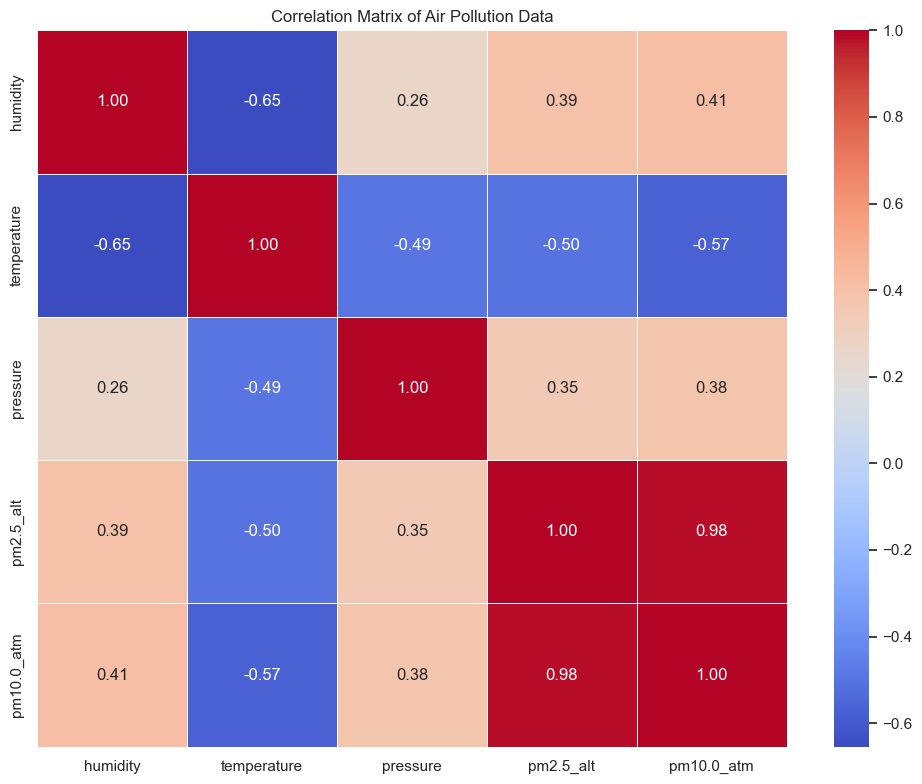

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title("Correlation Matrix of Air Pollution Data")
plt.tight_layout()
plt.show()


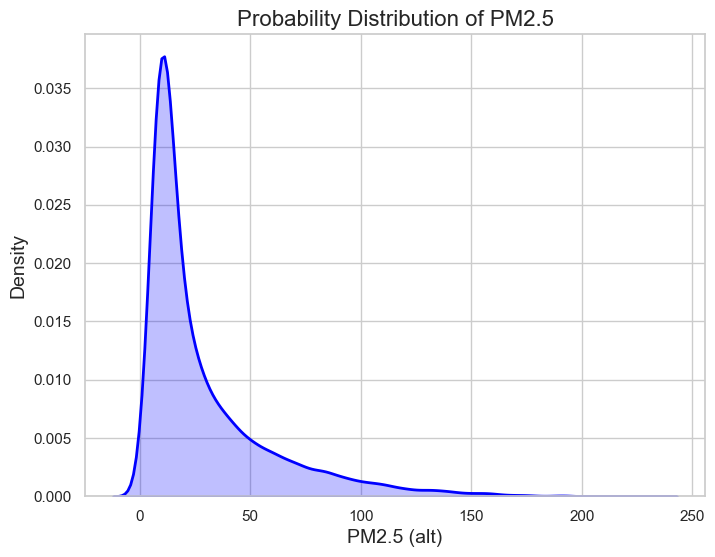

In [30]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.kdeplot(df['pm2.5_alt'], fill=True, color='blue', linewidth=2)
plt.title('Probability Distribution of PM2.5', fontsize=16)
plt.xlabel('PM2.5 (alt)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()


Add 5% Gaussian noise to pm2.5_alt

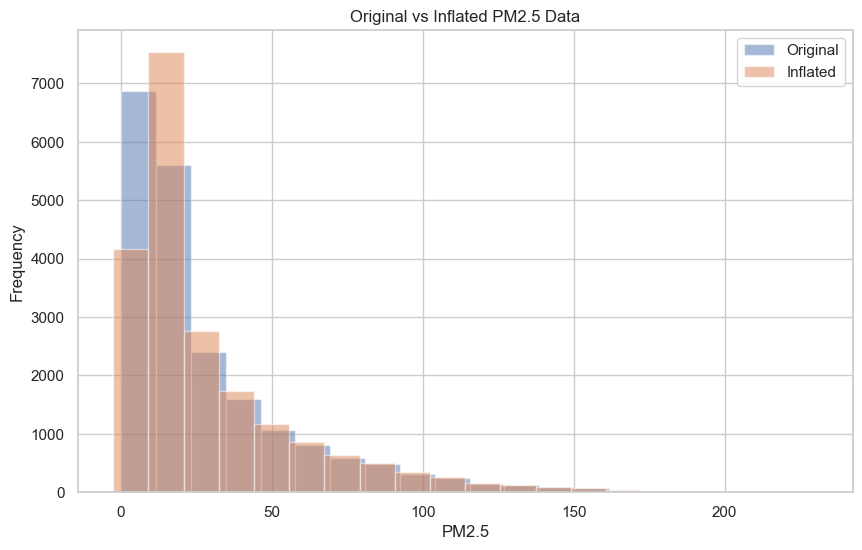

In [32]:
df = pd.read_csv(file_path)
noise_factor = 0.05  # 5% noise
noise = np.random.normal(0, noise_factor * df['pm2.5_alt'].std(), size=len(df))
df['pm2.5_alt_inflated'] = df['pm2.5_alt'] + noise
plt.figure(figsize=(10, 6))
plt.hist(df['pm2.5_alt'], bins=20, alpha=0.5, label='Original')
plt.hist(df['pm2.5_alt_inflated'], bins=20, alpha=0.5, label='Inflated')
plt.legend()
plt.title('Original vs Inflated PM2.5 Data')
plt.xlabel('PM2.5')
plt.ylabel('Frequency')
plt.show()

## Kentron data analysis

In [34]:
kentron_data = pd.read_csv("../Data/Raw data/Daily data/daily_pm25_data.csv", delimiter=',')
kentron_data.rename(columns={'median': 'pm2.5'}, inplace=True)

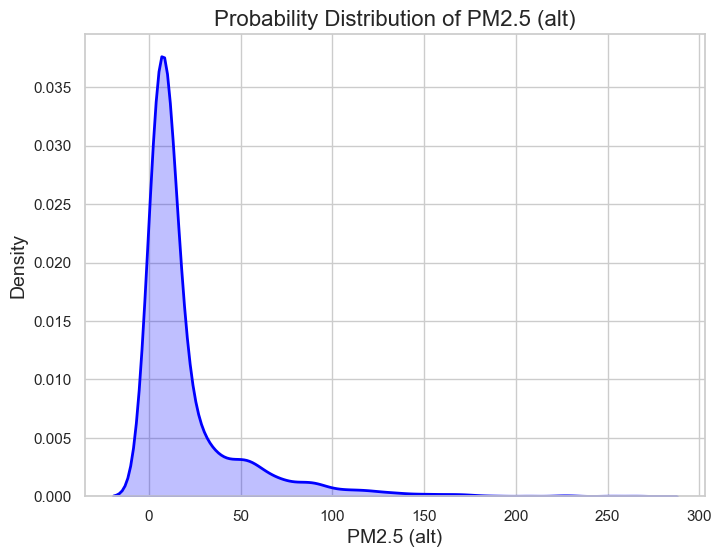

In [35]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.kdeplot(kentron_data['pm2.5'], fill=True, color='blue', linewidth=2)
plt.title('Probability Distribution of PM2.5 (alt)', fontsize=16)
plt.xlabel('PM2.5 (alt)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

In [36]:
kentron_data['date'] = pd.to_datetime(kentron_data['date'])
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

merged_dataset = pd.merge(kentron_data[['date', 'pm2.5']], df[['time_stamp', 'pm2.5_alt', 'humidity', 'temperature', 'pressure']], 
                          left_on='date', right_on='time_stamp', how='inner')

merged_dataset = merged_dataset[['date', 'pm2.5', 'pm2.5_alt', 'humidity', 'temperature', 'pressure']]

Convert AQI to PM2.5

In [37]:
def calculate_aqi(pm2_5_concentration):
    if pm2_5_concentration <= 12.0:
        aqi = (pm2_5_concentration / 12.0) * 50
    elif 12.1 <= pm2_5_concentration <= 35.4:
        aqi = ((pm2_5_concentration - 12.1) / (35.4 - 12.1)) * (100 - 51) + 51
    elif 35.5 <= pm2_5_concentration <= 55.4:
        aqi = ((pm2_5_concentration - 35.5) / (55.4 - 35.5)) * (150 - 101) + 101
    elif 55.5 <= pm2_5_concentration <= 150.4:
        aqi = ((pm2_5_concentration - 55.5) / (150.4 - 55.5)) * (200 - 151) + 151
    elif 150.5 <= pm2_5_concentration <= 250.4:
        aqi = ((pm2_5_concentration - 150.5) / (250.4 - 150.5)) * (300 - 201) + 201
    elif 250.5 <= pm2_5_concentration <= 500.4:
        aqi = ((pm2_5_concentration - 250.5) / (500.4 - 250.5)) * (500 - 301) + 301
    else:
        aqi = 500  # for concentrations above 500.4 µg/m³, the AQI is 500 (Hazardous)
    return aqi

merged_dataset['pm2.5_aqi'] = merged_dataset['pm2.5_alt'].apply(calculate_aqi)

In [38]:
merged_dataset.head()

,date,pm2.5,pm2.5_alt,humidity,temperature,pressure,pm2.5_aqi
0,2021-06-19 00:00:00+00:00,5.93,10.7,23.000,87.800,860.762,44.583333
1,2021-06-20 00:00:00+00:00,6.22,4.8,19.000,87.100,859.215,20.000000
2,2021-06-21 00:00:00+00:00,7.06,0.7,18.000,94.000,861.885,2.916667
3,2021-10-08 00:00:00+00:00,9.27,8.8,50.433,54.767,904.738,36.666667
4,2021-10-09 00:00:00+00:00,10.93,15.5,52.567,52.600,904.770,58.150215


<Figure size 640x480 with 0 Axes>

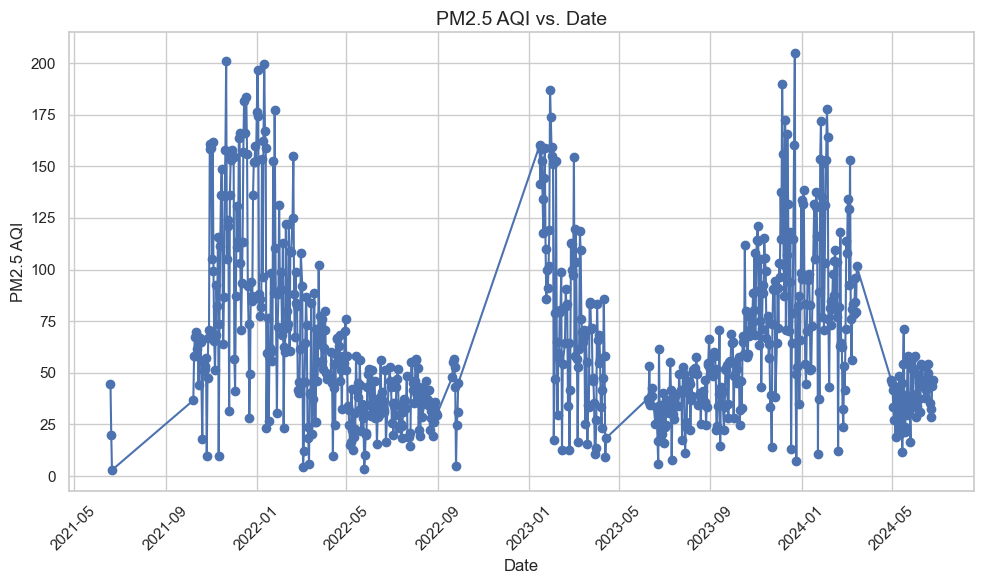

In [39]:
merged_dataset['date'] = pd.to_datetime(merged_dataset['date'])
plt.tight_layout()  # Add this before saving
plt.figure(figsize=(10, 6))
plt.plot(merged_dataset['date'], merged_dataset['pm2.5_aqi'], marker='o', linestyle='-', color='b')
plt.title('PM2.5 AQI vs. Date', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('PM2.5 AQI', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [40]:
merged_dataset['pm2.5_avg'] = merged_dataset[['pm2.5_aqi', 'pm2.5_alt']].mean(axis=1)

In [44]:
df_merged = merged_dataset[['date', 'pm2.5_avg', 'humidity', 'temperature', 'pressure']]
df_merged = df_merged.rename(columns={'time_stamp': 'date'})

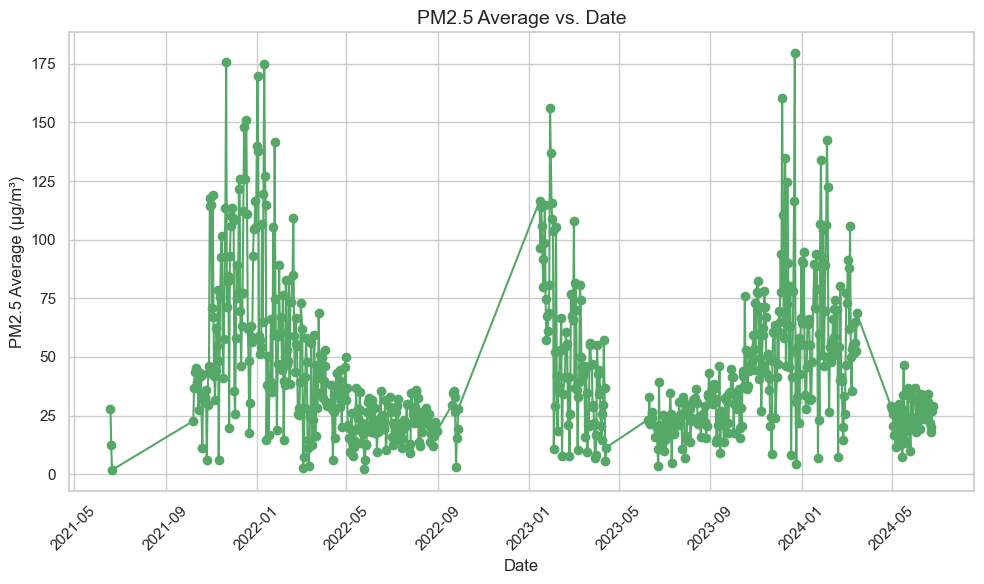

In [45]:
df_merged['date'] = pd.to_datetime(df_merged['date'])
plt.figure(figsize=(10, 6))
plt.plot(df_merged['date'], df_merged['pm2.5_avg'], marker='o', linestyle='-', color='g')
plt.title('PM2.5 Average vs. Date', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('PM2.5 Average (µg/m³)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
